# Bootstrap: How to get insights from (not so) small samples!

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats

# Metric we will use for sliding window, just one of the (almost) infinite scenarios where you can use bootstrapping

from sklearn.metrics import root_mean_squared_error

In [ ]:
# Sliding window-like search for validity ranges between two mass estimators for MBH. Just a scenario where bootstrapping can help you.

def val_range(method_A, method_B, percent_sample=0.1, rmse_min_threshold=0.2, scale_prop=0.2, min_log_dist=2):
    # Minimum number of points to consider valid
    min_sample_size = int(len(method_A) * percent_sample)
    
    # Step 1: compute the complete RMSE for the entire range of data
    complete_rmse = root_mean_squared_error(method_A, method_B)
    
    # Step 2: sliding window approach (starting with widest ranges first)
    best_rmse = None
    best_valid_range_A = None
    best_valid_range_B = None

    n = len(method_A)

    # Iterate from largest possible window size down to the minimum sample size
    for window_size in range(n, min_sample_size - 1, -1):
        for start in range(n - window_size + 1):
            end = start + window_size
            valid_values_A = method_A[start:end]
            valid_values_B = method_B[start:end]
            
            # Calculate RMSE for this sub-range
            block_rmse = root_mean_squared_error(valid_values_A, valid_values_B)
            
            # Check if RMSE is within the acceptable range
            if rmse_min_threshold < block_rmse <= complete_rmse:
                # Use min and max to check the range breadth (handles unsorted arrays)
                min_A, max_A = np.min(valid_values_A), np.max(valid_values_A)

                # Compare the amplitude of this range and save the best one
                if best_valid_range_A is None or ((((max_A-min_A)-(np.max(best_valid_range_A)-np.min(best_valid_range_A)))<scale_prop) and ((max_A-min_A)>min_log_dist)):
                    best_rmse = block_rmse
                    best_valid_range_A = valid_values_A
                    best_valid_range_B = valid_values_B

    # Output the best validity range and corresponding RMSE
    if best_valid_range_A is not None:
        print(f'Best Validity Range for Method A: ({np.min(best_valid_range_A)}, {np.max(best_valid_range_A)})')
        print(f'Best Validity Range for Method B: ({np.min(best_valid_range_B)}, {np.max(best_valid_range_B)})')
        print(f'Best RMSE: {best_rmse}')

        return [np.min(best_valid_range_A), np.max(best_valid_range_A)], [np.min(best_valid_range_B), np.max(best_valid_range_B)], best_rmse
    else:
        print('No suitable validity range found.')
        return [np.min(method_A), np.max(method_A)], [np.min(method_B), np.max(method_B)], complete_rmse


def bootstrap_rmse(method_A, method_B, n_iterations):
    n = len(method_A)
    rmse_bootstrap = []

    # Bootstrap resampling
    for i in range(n_iterations):
        # Resample with replacement
        indices = np.random.randint(0, n, size=n)
        resample_A = method_A[indices]
        resample_B = method_B[indices]
        
        # Calculate RMSE for the resampled data
        rmse = root_mean_squared_error(resample_A, resample_B)
        rmse_bootstrap.append(rmse)

    return np.array(rmse_bootstrap)

In [3]:
sample_good = pd.read_csv('bootstrap_good.csv')
sample_bad = pd.read_csv('bootstrap_bad.csv')

In [24]:
len(sample_good), len(sample_bad)

(570, 773)

In [18]:
sample_good.head()

,Unnamed: 0,MBH_SIGMA,MBH_WISE
0,0,8.764496,9.472618
1,1,8.979866,8.641933
2,2,7.698326,8.260317
3,3,6.678297,7.723074
4,4,8.986622,8.521954


# Sample exploration

In [4]:
rmse_good = root_mean_squared_error(sample_good['MBH_WISE'], sample_good['MBH_SIGMA'])
rmse_bad = root_mean_squared_error(sample_bad['MBH_WISE'], sample_bad['MBH_SIGMA'])

In [5]:
rmse_good

0.4816377477049841

In [6]:
rmse_bad

0.6193750995124268

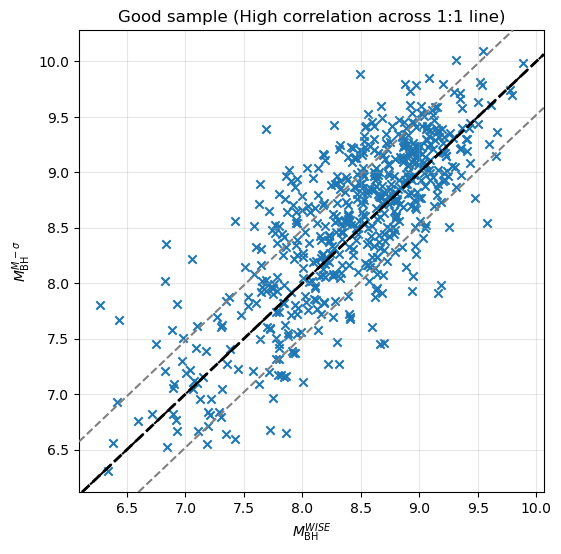

In [ ]:
plt.figure(figsize=(6,6))

sp = 8

plt.scatter(sample_good['MBH_WISE'], sample_good['MBH_SIGMA'], marker='x')
plt.axline((sp,sp),slope=1, zorder=99, ls='--', lw=2, color='k')

plt.axline((sp,sp+rmse_good), slope=1, color='grey', ls='--', zorder=99)
plt.axline((sp,sp), slope=1, color='k', ls='--', zorder=99)
plt.axline((sp,sp-rmse_good), slope=1, color='grey', ls='--', zorder=99)

plt.title('Good sample (Low scatter across 1:1 line)')

plt.ylabel(r'$M_{\rm BH}^{M-\sigma}$')
plt.xlabel(r'$M_{\rm BH}^{WISE}$')

plt.grid(True, alpha=0.3)

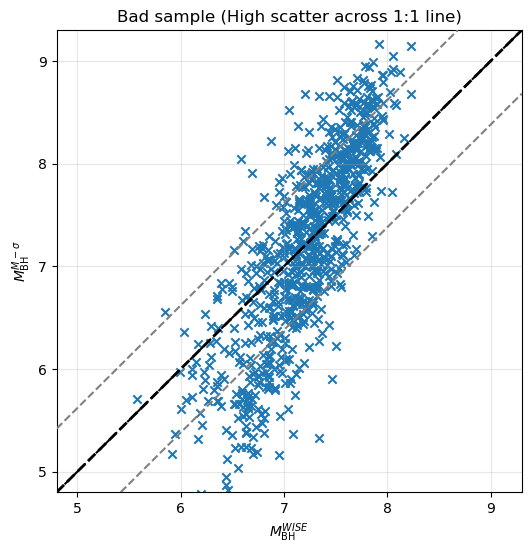

In [21]:
plt.figure(figsize=(6,6))
plt.xlim(4.8,9.3)
plt.ylim(4.8,9.3)


sp = 8

plt.scatter(sample_bad['MBH_WISE'], sample_bad['MBH_SIGMA'], marker='x')
plt.axline((sp,sp),slope=1, zorder=99, ls='--', lw=2, color='k')

plt.axline((sp,sp+rmse_bad), slope=1, color='grey', ls='--', zorder=99)
plt.axline((sp,sp), slope=1, color='k', ls='--', zorder=99)
plt.axline((sp,sp-rmse_bad), slope=1, color='grey', ls='--', zorder=99)

plt.title('Bad sample (High scatter across 1:1 line)')

plt.ylabel(r'$M_{\rm BH}^{M-\sigma}$')
plt.xlabel(r'$M_{\rm BH}^{WISE}$')

plt.grid(True, alpha=0.3)

# First Scenario: Smaller sample than the original
Can we reproduce the statistical results of the complete sample?

In [98]:
N = 200

sample_good_smaller = sample_good.sample(n=N).reset_index(drop=True)

In [99]:
sample_good_smaller.head()

,Unnamed: 0,MBH_SIGMA,MBH_WISE
0,505,8.068743,8.149700
1,410,8.559401,8.373141
2,14,8.951786,8.090482
3,143,8.601725,8.387710
4,511,9.261143,9.205779


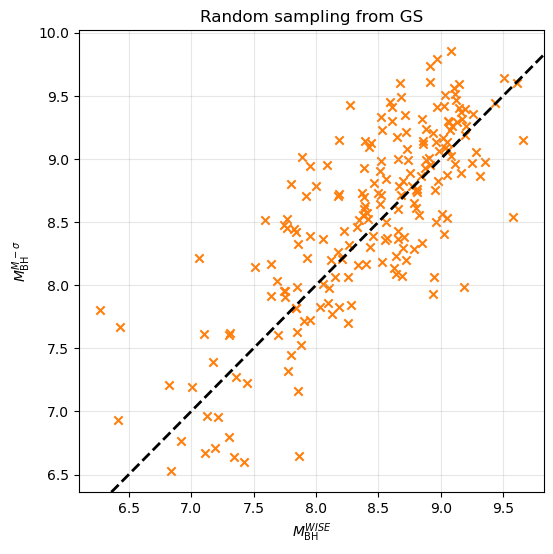

In [100]:
plt.figure(figsize=(6,6))

sp = 8

plt.scatter(sample_good_smaller['MBH_WISE'], sample_good_smaller['MBH_SIGMA'], marker='x', color='tab:orange')
plt.axline((sp,sp),slope=1, zorder=99, ls='--', lw=2, color='k')

plt.title('Random sampling from GS')

plt.ylabel(r'$M_{\rm BH}^{M-\sigma}$')
plt.xlabel(r'$M_{\rm BH}^{WISE}$')

plt.grid(True, alpha=0.3)

In [101]:
rmse_smaller = root_mean_squared_error(sample_good_smaller['MBH_WISE'], sample_good_smaller['MBH_SIGMA'])

In [102]:
dist_smaller = bootstrap_rmse(sample_good_smaller['MBH_WISE'],sample_good_smaller['MBH_SIGMA'], n_iterations=1000)

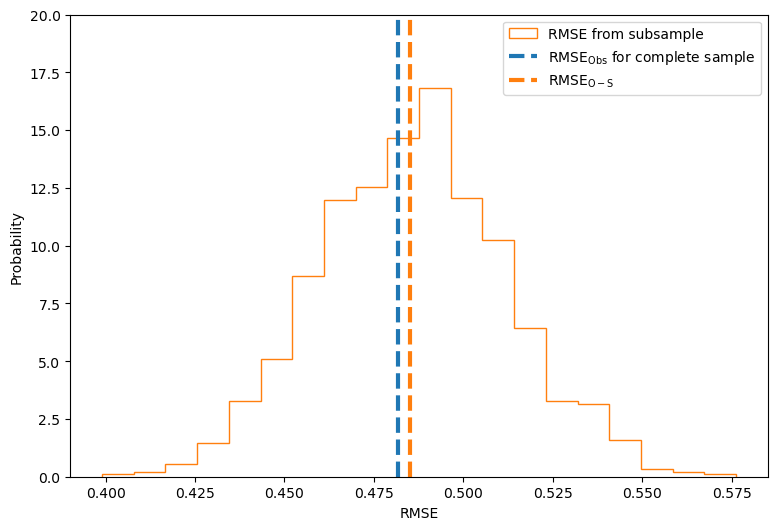

In [103]:
plt.figure(figsize=(9,6))
plt.ylim(0,20)

plt.hist(x=dist_smaller, fill=False, bins=20, histtype='step', density=True, label='RMSE from subsample', color='tab:orange') 

plt.vlines(x=rmse_good, ymin=0, ymax=20, lw=3, ls='--', label=r'RMSE$_{\rm Obs}$ for complete sample')
plt.vlines(x=rmse_smaller, ymin=0, ymax=20, lw=3, color='tab:orange', ls='--', label=r'RMSE$_{\rm O-S}$')

plt.xlabel('RMSE')
plt.ylabel('Probability')

plt.legend()

# Second Scenario: Finding validity ranges (VRs) between two methods
In a smaller region of comparison, is the scatter **truly** smaller?

In [ ]:
# Run under you own responsability. Can take several minutes!

# vr_good = val_range(sample_good['MBH_WISE'], sample_good['MBH_SIGMA'])
# vr_bad = val_range(sample_bad['MBH_WISE'], sample_bad['MBH_SIGMA'])

# np.save('vr_good.npy', np.asarray(vr_good, dtype='object'))
# np.save('vr_bad.npy', np.asarray(vr_bad, dtype='object'))

In [10]:
with open('vr_good.npy', 'rb') as f:
    vr_good = np.load(f, allow_pickle=True)

with open('vr_bad.npy', 'rb') as f:
    vr_bad = np.load(f, allow_pickle=True)

In [22]:
vr_good

array([list([7.605505269921355, 9.661866115798084]),
       list([7.152524471282959, 9.796283721923828]), 0.47186766960516213],
      dtype=object)

In [23]:
vr_bad

array([list([6.108737429340343, 8.121704526270658]),
       list([5.335278511047363, 8.891937255859375]), 0.5457696601666248],
      dtype=object)

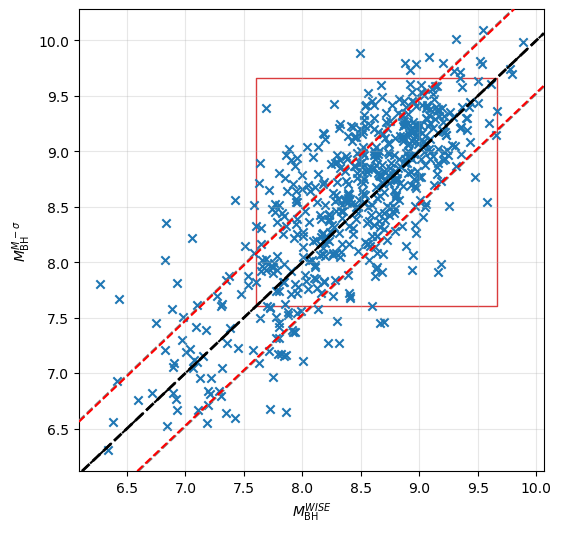

In [11]:
plt.figure(figsize=(6,6))

sp = 8

plt.scatter(sample_good['MBH_WISE'], sample_good['MBH_SIGMA'], marker='x')
plt.axline((sp,sp),slope=1, zorder=99, ls='--', lw=2, color='k')

plt.axline((sp,sp+rmse_good), slope=1, color='grey', ls='--', zorder=99)
plt.axline((sp,sp), slope=1, color='k', ls='--', zorder=99)
plt.axline((sp,sp-rmse_good), slope=1, color='grey', ls='--', zorder=99)

min_value = max(vr_good[0][0], vr_good[1][0])
max_value = min(vr_good[0][1], vr_good[1][1])

plt.fill_betweenx([min_value,max_value], 
                x1=min_value, x2=max_value, 
                edgecolor='tab:red',facecolor='w', alpha=0.9, zorder=-99)

plt.axline((sp,sp+vr_good[2]), slope=1, color='red', ls='--', zorder=99)
plt.axline((sp,sp-vr_good[2]), slope=1, color='red', ls='--', zorder=99)

plt.ylabel(r'$M_{\rm BH}^{M-\sigma}$')
plt.xlabel(r'$M_{\rm BH}^{WISE}$')

plt.grid(True, alpha=0.3)

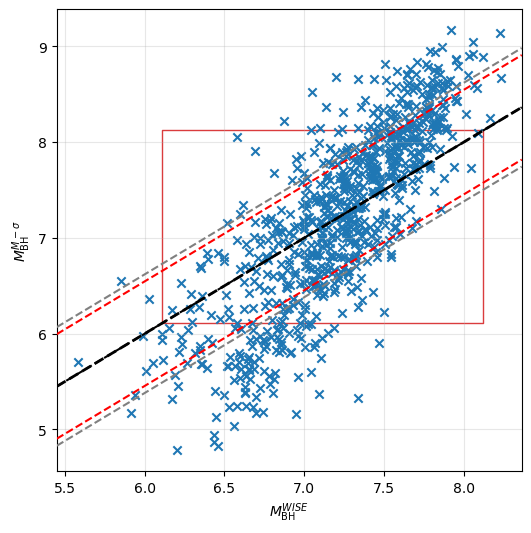

In [12]:
plt.figure(figsize=(6,6))

sp = 8

plt.scatter(sample_bad['MBH_WISE'], sample_bad['MBH_SIGMA'], marker='x')
plt.axline((sp,sp),slope=1, zorder=99, ls='--', lw=2, color='k')

plt.axline((sp,sp+rmse_bad), slope=1, color='grey', ls='--', zorder=99)
plt.axline((sp,sp), slope=1, color='k', ls='--', zorder=99)
plt.axline((sp,sp-rmse_bad), slope=1, color='grey', ls='--', zorder=99)

min_value = max(vr_bad[0][0], vr_bad[1][0])
max_value = min(vr_bad[0][1], vr_bad[1][1])

plt.fill_betweenx([min_value,max_value], 
                x1=min_value, x2=max_value, 
                edgecolor='tab:red',facecolor='w', alpha=0.9, zorder=-99)

plt.axline((sp,sp+vr_bad[2]), slope=1, color='red', ls='--', zorder=99)
plt.axline((sp,sp-vr_bad[2]), slope=1, color='red', ls='--', zorder=99)

plt.ylabel(r'$M_{\rm BH}^{M-\sigma}$')
plt.xlabel(r'$M_{\rm BH}^{WISE}$')

plt.grid(True, alpha=0.3)

# Bootstrap to avoid sample bias

In [13]:
min_value = max(vr_good[0][0], vr_good[1][0])
max_value = min(vr_good[0][1], vr_good[1][1])

idxs = (sample_good['MBH_WISE']<max_value) & (sample_good['MBH_WISE']>min_value)

dist_complete = bootstrap_rmse(sample_good['MBH_WISE'],sample_good['MBH_SIGMA'], n_iterations=10000)
dist_valrange = bootstrap_rmse(sample_good['MBH_WISE'].values[idxs], sample_good['MBH_SIGMA'].values[idxs], n_iterations=10000)
pvalue = stats.ks_2samp(dist_complete,dist_valrange).pvalue
print(pvalue)

1.9823067146067e-311


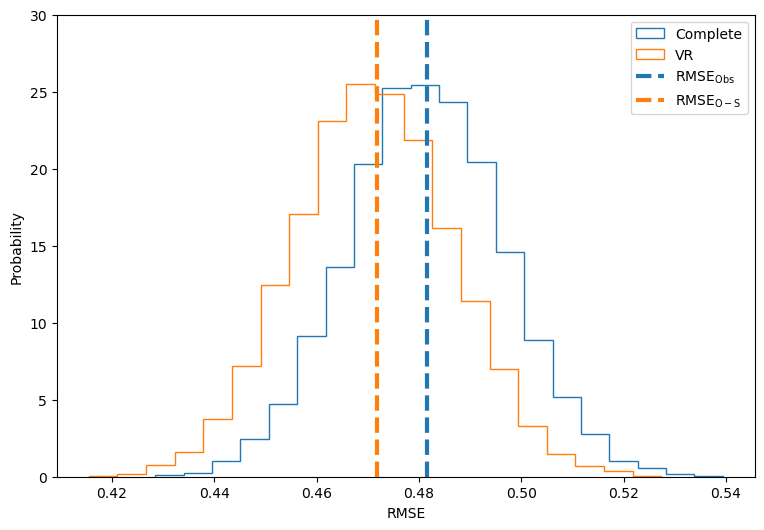

In [14]:
plt.figure(figsize=(9,6))
plt.ylim(0,30)

plt.hist(x=dist_complete, fill=False, bins=20, histtype='step', density=True, label='Complete') 
plt.hist(x=dist_valrange, fill=False, bins=20, histtype='step', density=True, label='VR')

plt.vlines(x=rmse_good, ymin=0, ymax=30, lw=3, ls='--', label=r'RMSE$_{\rm Obs}$')
plt.vlines(x=vr_good[2], ymin=0, ymax=30, lw=3, color='tab:orange', ls='--', label=r'RMSE$_{\rm O-S}$')

plt.xlabel('RMSE')
plt.ylabel('Probability')

plt.legend()

In [15]:
min_value = max(vr_bad[0][0], vr_bad[1][0])
max_value = min(vr_bad[0][1], vr_bad[1][1])

idxs = (sample_bad['MBH_WISE']<max_value) & (sample_bad['MBH_WISE']>min_value)

dist_complete = bootstrap_rmse(sample_bad['MBH_WISE'],sample_bad['MBH_SIGMA'], n_iterations=10000)
dist_valrange = bootstrap_rmse(sample_bad['MBH_WISE'].values[idxs], sample_bad['MBH_SIGMA'].values[idxs], n_iterations=10000)
pvalue = stats.ks_2samp(dist_complete,dist_valrange).pvalue
print(pvalue)

6.585166088811949e-13


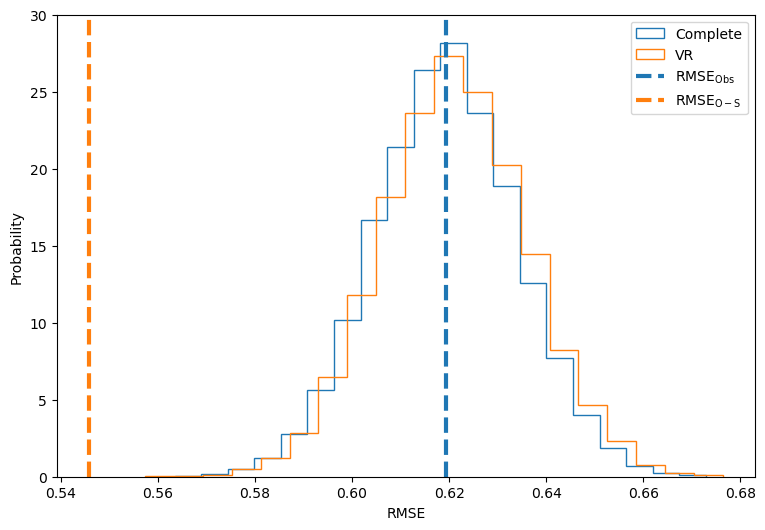

In [16]:
plt.figure(figsize=(9,6))
plt.ylim(0,30)

plt.hist(x=dist_complete, fill=False, bins=20, histtype='step', density=True, label='Complete') 
plt.hist(x=dist_valrange, fill=False, bins=20, histtype='step', density=True, label='VR')

plt.vlines(x=rmse_bad, ymin=0, ymax=30, lw=3, ls='--', label=r'RMSE$_{\rm Obs}$')
plt.vlines(x=vr_bad[2], ymin=0, ymax=30, lw=3, color='tab:orange', ls='--', label=r'RMSE$_{\rm O-S}$')

plt.xlabel('RMSE')
plt.ylabel('Probability')

plt.legend()